# Prediction on one parcel 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
sys.path.append("..")
from data import BreizhCrops
import torch
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times, plot_timestamps_left_per_class
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_config import set_up_config, save_config, print_config
from utils.test.helpers_testing import get_test_stats_from_model
from utils.test.helpers_testing import get_test_stats_from_model, load_test_dataset, save_test_stats
import matplotlib.pyplot as plt
from utils.plots_test import plot_confusion_matrix, plot_fig_class_prob_wrt_time_with_mus
from utils.test.load_model import get_all_runs, get_best_run, get_loaded_model_and_criterion, \
    get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.metrics import get_std_score
from utils.plots_test import plots_all_figs_at_test
import argparse
from data.breizhcrops import SELECTED_BANDS


In [3]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

Local dataroot:  C:\Users\anyam\elects_data


Download the model from wandb


In [4]:
entity, project, sweep = "aurenore", "MasterThesis", "final_experience"
runs_df, runs = get_all_runs(entity, project)
df = runs_df[runs_df.sweep == sweep]

give run name:

In [5]:
run_name = "v1"

In [6]:
# get the run with name:
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# get and save the config
config_path = save_config(model_path, run)
print_config(run)
args  = set_up_config(run_config)
args.dataroot = local_dataroot

wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-5dazxzo8-model.pth-v27\config.json
-------------------------------------------------- Configuration: --------------------------------------------------
mu: 150
mus: [122, 72, 102, 103, 150, 150, 150]
loss: daily_reward_piecewise_lin_regr
alpha: 1
device: cuda
epochs: 100
factor: v1
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 128
corrected: True
alpha_decay: [1, 0.4]
hidden_dims: 128
loss_weight: balanced
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 264994
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bia

load test dataset

In [7]:
test_ds, nclasses, class_names, input_dim = load_test_dataset(args)

2493572704 2493572704


loading data into RAM: 100%|██████████| 2463/2463 [00:01<00:00, 1379.32it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [00:12<00:00, 2978.93it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


## load the model 

In [8]:
# ## Load the models and the criterions
mus = get_mus_from_config(args)
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)
model.eval()

wandb:   1 of 1 files downloaded.  


loss daily_reward_piecewise_lin_regr selected, mus set to tensor([122,  72, 102, 103, 150, 150, 150])
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-5dazxzo8-model.pth-v27
The model has 264,994 trainable parameters.


c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\..\utils\test\load_model.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)


DailyEarlyRNN(
  (intransforms): Sequential(
    (0): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=13, out_features=128, bias=True)
  )
  (backbone): LSTM(128, 128, num_layers=2, bias=False, batch_first=True, dropout=0.2)
  (classification_head): ClassificationHead(
    (projection): Sequential(
      (0): Linear(in_features=128, out_features=7, bias=True)
      (1): LogSoftmax(dim=2)
    )
  )
  (stopping_decision_head): DecisionHeadDay(
    (projection): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

## predict on one parcel 

In [9]:
id_parcel = 5
X, y_true, ids = test_ds[id_parcel]
X, y_true = X.to(args.device), y_true.to(args.device)
print("shapes: ", X.shape, y_true.shape)
print("ids: ", ids)
# change the shape of X to be able to use it in the model
X = X.unsqueeze(0)
y_true = y_true.unsqueeze(0)

shapes:  torch.Size([365, 13]) torch.Size([365])
ids:  5399696


predict the parcel: 

In [10]:
dict_pred = {"epoch": args.epochs, "criterion_alpha": args.alpha_decay[1]}
log_class_probabilities, stopping_criteria, predictions_at_t_stop, t_stop = model.predict(X, **dict_pred)
#  move to cpu 
log_class_probabilities = log_class_probabilities.cpu()
stopping_criteria = stopping_criteria.cpu()
predictions_at_t_stop = predictions_at_t_stop.cpu()
t_stop = t_stop.cpu()


Figure saved at: c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-5dazxzo8-model.pth-v27\one_parcel_prediction.png
Predicted label:  temporary meadows
True label:  temporary meadows


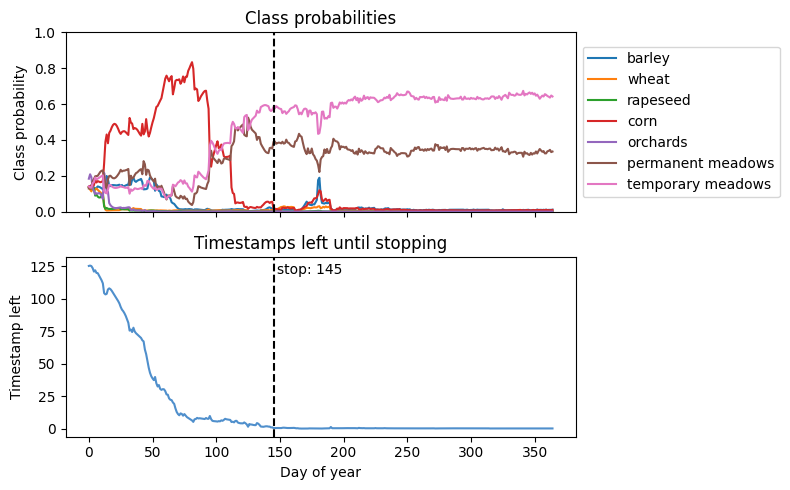

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
# plot the classification probabilities with respect to time 
axes[0].plot(log_class_probabilities[0].exp().detach().numpy(), label=class_names)
axes[0].set_title("Class probabilities")
axes[0].set_ylim(0,1)
axes[0].set_ylabel("Class probability")
# set the legend on the right of the plot
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# define a color which hasn't been used yet
color = "#4F8FCC"
axes[1].plot(stopping_criteria[0].detach().numpy(), color=color)
axes[1].set_title("Timestamps left until stopping")
axes[1].set_xlabel("Day of year")
axes[1].set_ylabel("Timestamp left")

# set a vertical line at the stopping time t_stop 
for ax in axes:
    ax.axvline(x=t_stop, color='black', linestyle='--')
# add t_stop at the vertical line
ymin, ymax = axes[1].get_ylim()
axes[1].text(t_stop+3., ymax-10., f"stop: {t_stop.item()}", verticalalignment='center')
fig.tight_layout()
# save the figure 
fig_filename = os.path.join(model_path, "one_parcel_prediction.png")
fig.savefig(fig_filename, bbox_inches='tight')
print(f"Figure saved at: {fig_filename}")

print("Predicted label: ", class_names[predictions_at_t_stop.item()])
print("True label: ", class_names[y_true[0,0]])

plot the spectral bands:

In [12]:
# transfer the data to the cpu
X = X.cpu().detach().numpy().squeeze()

In [13]:
# get the indices, a list of the indices of the non zero elements
idx = [i for i, x in enumerate(X[:,0]!=0) if x]
print("idx: ", idx)

idx:  [2, 5, 12, 15, 25, 32, 35, 42, 45, 52, 55, 62, 65, 72, 75, 82, 85, 92, 95, 102, 105, 112, 115, 122, 125, 132, 135, 142, 145, 152, 155, 162, 165, 172, 175, 180, 182, 185, 187, 190, 192, 195, 197, 200, 202, 205, 207, 210, 212, 215, 217, 220, 225, 227, 230, 232, 235, 237, 242, 245, 250, 252, 255, 257, 260, 262, 265, 267, 270, 272, 275, 277, 280, 282, 292, 295, 297, 300, 302, 305, 307, 310, 312, 315, 317, 320, 322, 325, 327, 330, 332, 335, 340, 342, 345, 347, 350, 352, 355, 357, 360, 362]


Figure saved at: c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-5dazxzo8-model.pth-v27\one_parcel_data.png


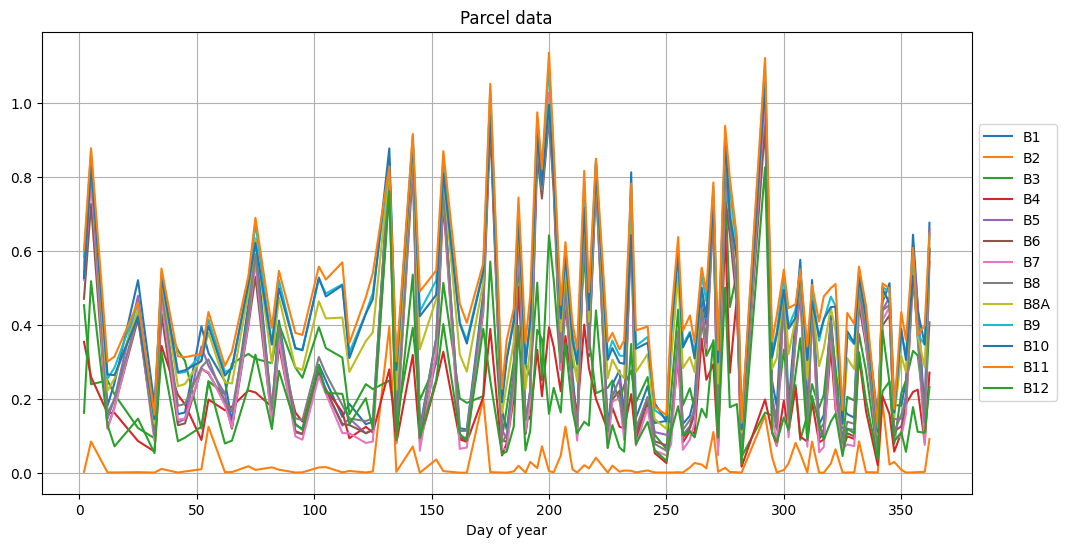

In [17]:
# plot the data
fig, ax = plt.subplots(1, figsize=(12,6))

# only plot the non zero elements
for i in range(13):
    ax.plot(idx, X[X[:,i]!=0,i], label=f"{SELECTED_BANDS['L1C'][i]}")

ax.set_title("Parcel data")
ax.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Day of year")
ax.grid()
# save the figure 
fig_filename = os.path.join(model_path, "one_parcel_data.png")
fig.savefig(fig_filename, bbox_inches='tight')
print(f"Figure saved at: {fig_filename}")
